# Тема: «Моделирование взаимосвязей макроэкономических процессов в странах мира»

In [1]:
#Importing the required python libraries
#Импорт необходимых библиотек Python
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.offline as offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
mpl.style.use(['ggplot'])
pd.set_option('display.max_rows',220)
pd.set_option('display.max_columns',25)
import wbgapi as wb
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression



## I- Get Data

### 1- страны и регионы по всему миру

In [2]:
# использовала библиотеку wbgapi для получения данных с сайта группы Всемирного банка
countries=wb.economy.DataFrame(labels=True)

In [3]:
countries.head()

,name,aggregate,longitude,latitude,region,adminregion,lendingType,incomeLevel,capitalCity
id,,,,,,,,,
ABW,Aruba,False,-70.0167,12.51670,Latin America & Caribbean,None,Not classified,High income,Oranjestad
AFE,Africa Eastern and Southern,True,NaN,NaN,None,None,None,None,
AFG,Afghanistan,False,69.1761,34.52280,South Asia,South Asia,IDA,Low income,Kabul
AFW,Africa Western and Central,True,NaN,NaN,None,None,None,None,
AGO,Angola,False,13.2420,-8.81155,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),IBRD,Lower middle income,Luanda


### 2- используемые макроэкономические показатели

In [4]:
# экономические показатели, влияющие на ВВП
indicators={
#     GDP
    'NY.GDP.MKTP.CD':"ВВП",
#     final consumption
    'NE.CON.TOTL.CD':'Конечное потребление',
#    Government final consumption
    'NE.CON.GOVT.CD':'Конечное потребление правительства',
#     gross capital formation
    'NE.GDI.TOTL.CD':'Валовое накопление капитала',
# импорт - экспорт
    'NE.IMP.GNFS.CD':'Импорт',
    'NE.EXP.GNFS.CD':'Экспорт',
# уровень безработицы
    'SL.UEM.TOTL.ZS':'Уровень безработицы',
}

### 3- Данные таблицы экономических показателей стран мира в 2020 году

In [5]:
df=wb.data.DataFrame(indicators.keys(),['all'], time=2020,labels=True,skipAggs=True)

#добавить столбцы "region" во фреймы данных. регион взят из countries таблица
df[['region']]=countries[['region']]

#put region after countries
df.insert(1,'Region',df['region']) 

df.drop(['region'],axis=1,inplace=True)

#установить страну в качестве индекса
df=df.reset_index().set_index('Country')

df.rename(columns={i:j for i,j in zip(indicators.keys(),indicators.values())}, inplace=True)

In [6]:
df.head()

,economy,Region,Конечное потребление правительства,Конечное потребление,Экспорт,Валовое накопление капитала,Импорт,ВВП,Уровень безработицы
Country,,,,,,,,,
Zimbabwe,ZWE,Sub-Saharan Africa,1.400265e+09,1.699446e+10,6.715439e+09,1.345078e+09,7.003801e+09,1.805117e+10,5.351000
Zambia,ZMB,Sub-Saharan Africa,2.664372e+09,9.633632e+09,8.473994e+09,5.848491e+09,5.892352e+09,1.811063e+10,12.848000
"Yemen, Rep.",YEM,Middle East & North Africa,NaN,NaN,NaN,NaN,NaN,NaN,13.391000
West Bank and Gaza,PSE,Middle East & North Africa,3.646600e+09,1.752220e+10,2.495800e+09,3.634500e+09,7.948500e+09,1.556130e+10,25.889999
Virgin Islands (U.S.),VIR,Latin America & Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,13.545000


## II- data wrangling

In [7]:
#1-удалить страны без данных
df.dropna(inplace=True)

#2-вставьте столбец значений столбца «ВВП» во 2-ю позицию таблицы данных
#с названием GDP
df.insert(2,"GDP",df[['ВВП']])
#удалите столбец ВВП в таблице df,
#потому что у нас есть столбец ВВП и столбец GDP с одинаковыми данными
df.drop(['ВВП'], axis=1, inplace=True)
#Затем мы меняем название GDP на ВВП
df.rename(columns={'GDP':'ВВП'}, inplace=True)

df['Чистый экспорт']=df['Экспорт']-df['Импорт']
df.drop(['Экспорт','Импорт'],axis=1, inplace=True)

#3- преобразовать данные из долларов в миллиарды долларов
list_indicators=df.columns[2:]

df[list_indicators]=df[list_indicators].astype(float)

# игнорировать значение «уровень безработицы»
df[list_indicators[0:4]]=df[list_indicators[0:4]]/100000000
df[list_indicators[5]]=df[list_indicators[5]]/100000000

In [8]:
df.head()

,economy,Region,ВВП,Конечное потребление правительства,Конечное потребление,Валовое накопление капитала,Уровень безработицы,Чистый экспорт
Country,,,,,,,,
Zimbabwe,ZWE,Sub-Saharan Africa,180.511708,14.002647,169.944551,13.450775,5.351000,-2.883618
Zambia,ZMB,Sub-Saharan Africa,181.106314,26.643717,96.336315,58.484908,12.848000,25.816421
West Bank and Gaza,PSE,Middle East & North Africa,155.613000,36.466000,175.222000,36.345000,25.889999,-54.527000
Vietnam,VNM,East Asia & Pacific,2711.584424,182.025722,2021.974979,732.436239,2.390000,77.152774
Uzbekistan,UZB,Europe & Central Asia,599.299511,101.319030,449.767702,230.108501,7.041000,-80.576680


In [9]:
df.shape

(144, 8)

In [10]:
import os
if os.path.exists('data.csv'):
    pass
else:
    df.to_csv('data.csv', encoding='cp1251')


## III- Исследование данных (Data Exploration)

### 1- Распределение ВВП на карте мира в 2020 году(Distribution of GDP on the world map in 2020)

In [33]:
dft=df.reset_index()
# показать значение ВВП всех стран на карте мира. Шкала значений изменяется по цвету.
fig1= px.choropleth(dft, 
                    locations='economy',
                    color='ВВП',
                    hover_name='Country',
                    color_continuous_scale=px.colors.sequential.speed)
fig1.update_layout(
    title_text = 'Распределение ВВП на карте мира в 2020 году',
    title_x=0.5,
    title_font_size=25, font_color='black',
   )
fig1.show()
#  paper_bgcolor='#AEDBCE'

### 2-  ВВП регионов и стран мира в 2020 году (GDP of regions and countries in the world in 2020)

In [35]:
# нарисовать круговую диаграмму, показывающую страны и регионы
fig2=px.sunburst(dft[['Region','Country','ВВП']],
                 path=['Region',"Country"],
                 values='ВВП', 
                 color='ВВП')
fig2.update_layout(title_text = 'ВВП регионов и стран мира в 2020 году',
                   title_x=0.5,title_font_size=25, font_color='#001233',font_size=20,
                 )
fig2.show()

### 3- Топ-15 стран с самым высоким ВВП в мире в 2020 году (Top 15 countries with the highest GDP in the world)

In [13]:
#нарисуйте диаграмму 15 стран с самым большим значением ВВП в мире
top_15_highest=df.sort_values('ВВП', ascending=False)[['ВВП']].head(15)
fig3=px.bar(top_15_highest,
            y=top_15_highest.index, 
            x='ВВП', color='ВВП',
            text_auto='.2s',
            orientation='h',
            
       title="Топ-15 стран с самым высоким ВВП в мире в 2020 году")
fig3.update_layout(title_x=0.5,title_font_size=25,yaxis={'categoryorder':'total ascending'})
fig3.show()

In [14]:
top_15_highest

,ВВП
Country,
United States,209530.300000
China,147227.306979
Japan,50577.589587
Germany,38464.139287
United Kingdom,27598.040618
India,26602.452489
France,26303.177315
Italy,18887.094437
Canada,16454.234076


### 4- Топ-15 стран с самым низким ВВП в мире в 2020 году (Top 15 countries with the lowest GDP)

In [15]:
#нарисуйте диаграмму 15 стран с самым большим значением ВВП в мире
top_15_lowest=df.sort_values('ВВП', ascending=False)[['ВВП']].tail(15)
fig=px.bar(top_15_lowest,y=top_15_lowest.index, x='ВВП', color='ВВП',  
           text_auto='.2s',
           title="Топ-15 стран с самым низким ВВП в мире в 2020 году",
           orientation='h')
fig.update_layout(title_x=0.5, title_font_size=25)
fig.show()

### 5- Гистограмма ВВП (Histogram of GDP)

In [16]:
fig=px.histogram(df, x='ВВП', nbins=20, title='Гистограмма ВВП',
                 color_discrete_sequence=['#a5be00'] ,
                 text_auto='.s',width=1000
                 )
fig.update_layout(bargap=0.2, title_x=0.5, title_font_size=25)
fig.show()

In [17]:
df_bar=df[df.columns[3:]]
df_bar.drop(['Уровень безработицы'],axis=1,inplace=True)
df_bar=df_bar.transpose()
df_bar.reset_index(inplace=True)
list_country=list(df.index)

In [18]:
df_bar

Country,index,Zimbabwe,Zambia,West Bank and Gaza,Vietnam,Uzbekistan,United States,United Kingdom,Ukraine,Uganda,Turkey,Tonga,...,Belize,Belgium,Belarus,Bangladesh,"Bahamas, The",Azerbaijan,Austria,Australia,Armenia,Argentina,Angola,Algeria
0,Конечное потребление правительства,14.002647,26.643717,36.466,182.025722,101.319030,30779.90,6167.387962,299.626449,35.763269,1092.702566,1.165073,...,3.278242,1292.020257,101.890884,202.624829,15.781,67.877059,918.488206,2770.116638,20.270791,604.619262,59.278406,291.654309
1,Конечное потребление,169.944551,96.336315,175.222,2021.974979,449.767702,171255.55,23000.281713,1455.328944,303.673370,5178.250502,6.007772,...,14.040852,3884.359968,411.989670,2462.530648,79.999,325.897059,3090.188843,9799.812307,115.580056,3077.364357,429.006908,990.457245
2,Валовое накопление капитала,13.450775,58.484908,36.345,732.436239,230.108501,44193.77,4608.656347,116.860243,91.053614,2295.664703,1.213046,...,3.649161,1260.872569,158.308739,984.303389,22.443,103.465294,1122.191572,2956.951334,23.427289,545.771334,97.843941,629.113529
3,Чистый экспорт,-2.883618,25.816421,-54.527,77.152774,-80.576680,-6511.87,36.653866,-16.369100,-23.203546,-274.366977,-2.117144,...,-2.192488,73.380389,18.792835,-211.277436,-1.344,-3.290588,124.391667,521.598069,-12.595247,118.168067,50.605300,-142.683835


In [19]:
#используйте ползунок, чтобы получить значение лет.
def f(country):
    try:
        fig = px.bar(df_bar, x="index", y=f'{country}',
                     title=f"Компоненты, влияющие на ВВП {country} в 2020 г. (по методу потребительских расходов)",
                     text_auto='.2s')
        fig.update_layout(bargap=0.2, title_x=0.5, title_font_size=18)

        fig.show()
    except:
        print('loading...')

interact(f, country=widgets.Combobox(options=list_country, value='Russian Federation'));

interactive(children=(Combobox(value='Russian Federation', description='country', options=('Zimbabwe', 'Zambia…

## IV- Correlation between Variables(Корреляция между переменными)

### 1- описательный статистический анализ (descriptive statistical analysis)

In [20]:
df.describe().transpose().style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
ВВП,144.000000,5723.528148,22062.383913,4.888300,149.582883,600.940951,3358.330926,209530.300000
Конечное потребление правительства,144.000000,1013.310023,3534.923599,1.165073,22.846622,92.207360,447.654931,30779.900000
Конечное потребление,144.000000,4182.281232,16357.247668,6.007772,120.883028,449.124967,2429.371283,171255.550000
Валовое накопление капитала,144.000000,1510.025435,6600.827456,1.213046,33.547193,124.453141,657.440180,64108.596105
Уровень безработицы,144.000000,8.035000,5.717388,0.214000,4.323250,6.342500,9.465000,29.219999
Чистый экспорт,144.000000,34.340246,686.503120,-6511.870000,-25.255189,-4.729336,41.007537,3661.446899


### 2- Корреляция мы можем рассчитать корреляцию Пирсона (Correlation - we can calculate the Pearson Correlation)

In [21]:
corr_matrix=df.corr()
fig=px.imshow(corr_matrix, text_auto='.3f',
              color_continuous_scale='ylgn', title='<b>Корреляция</b>', width=800)
fig.update_layout(title_x=0.5, title_font_size=25)
fig.show()

## V- Modeling (Моделирование)

### - зависимая переменная: Y- ВВП(GDP)
### - независимые переменные: x1- конечное потребление государства, x2-конечное потребление, x3- валовое накопление капитала, x4-Уровень безработицы , x5- Чистый экспорт


In [22]:
# mean_y=np.mean(df['ВВП'])
# disp_y=np.var(df['ВВП'])
# sigma_y=np.std(df['ВВП'])

# print("Среднее значение у=",mean_y)
# print("Дисперсия у=",disp_y)
# print("Среднее квадратическое отклонение у=",sigma_y,"\n")

#список имен независимых переменных
list_X=list(df.columns[3:])
list_X

['Конечное потребление правительства',
 'Конечное потребление',
 'Валовое накопление капитала',
 'Уровень безработицы',
 'Чистый экспорт']

In [23]:
# зависимая переменная y (ВВП):
y=df[['ВВП']]
# Government final consumption - конечное потребление государства
X1=df[[f'{list_X[0]}']] 
# Final consumption - конечное потребление
X2=df[[f'{list_X[1]}']] 
# GCF - валовое накопление капитала
X3=df[[f'{list_X[2]}']]
# Unemployment -безработица
X4=df[[f'{list_X[3]}']]
#чистый экспорт
X5=df[[f'{list_X[4]}']]

 #конечное потребление, конечное потребление государства, 
#валовое накопление капитала,чистый экспорт, безработица
Z=df[list_X]

### 1- Model1: Simple Linear Regression

In [24]:
def model(x):
    ml=LinearRegression()
    ml.fit(x,y)
    
    #прогнозируемое значение
    y_pred = ml.predict(x)
    
    #Среднеквадратическая ошибка
    mse=mean_squared_error(y,y_pred)
    
    #Root Mean Square Error
    rmse= np.sqrt(mse)
    
    #Коэффициент детерминации 
    R2=ml.score(x,y)
    
    f=f'{ml.intercept_[0]:.2f} + {ml.coef_[0][0]:.2f}*x'
    
    col_x=[f'{R2:.3f}',f'{rmse:.3f}',f]
    
    return col_x

In [25]:
model1=model(X1) #- конечное потребление государства
model2=model(X2) # Final consumption - конечное потребление
model3=model(X3) # GCF - валовое накопление капитала
model4=model(X4) # Unemployment -безработица
model5=model(X5) #чистый экспорт

### Результаты корреляционного анализа

In [26]:
#используйте ползунок, чтобы получить значение лет.
def f(x):
    try:
        fig = px.scatter(
        df, x=x, y='ВВП', opacity=0.65,
        trendline='ols', trendline_color_override='darkblue',width=500, height=300,
             title=f"<b>Модель с ВВП и {x}</b>")
        fig.update_layout(width=800, height=400,title_x=0.5)
        fig.show()
        results = px.get_trendline_results(fig)
        
        plt.figure(figsize=(12,5))
        g=sns.residplot(x=df[f'{x}'], y=df['ВВП'], data=df)
        g.set_title('График остатков')
        plt.show()
        
        print(f'Результаты корреляционного анализа между ВВП и {x}:')
        print(results.px_fit_results.iloc[0].summary())
    except:
        print('loading...')

interact(f, x=widgets.Combobox(options=list_X, value='Конечное потребление'));

interactive(children=(Combobox(value='Конечное потребление', description='x', options=('Конечное потребление п…

### 2-  Model2: Multiple Linear Simple

In [27]:
modelz=LinearRegression()
modelz.fit(Z,y)

y_pred_z= modelz.predict(Z)
#Среднеквадратическая ошибка
mse=mean_squared_error(y,y_pred_z)
#Root Mean Square Error
rmseZ= np.sqrt(mse)
#Коэффициент детерминации R^2
R2_Z=modelz.score(Z,y)

# Формула уравнения
fz=f'{modelz.intercept_[0]:.2f} + {modelz.coef_[0][0]:.2f}*x1 +{modelz.coef_[0][1]:.2f}*x2+{modelz.coef_[0][2]:.2f}*x3 +{modelz.coef_[0][3]:.2f}*x4 + {modelz.coef_[0][4]:.2f}*x5'

print("- Коэффициент детерминации R^2=",R2_Z)
print('- Среднеквадратическая ошибка RMSE:', rmseZ)
print("- Формула уравнения:",fz)

col_z=[f'{R2_Z:.3f}',f'{rmseZ:.3f}',fz]

- Коэффициент детерминации R^2= 0.9999976533727107
- Среднеквадратическая ошибка RMSE: 33.67916136260525
- Формула уравнения: 0.49 + -0.02*x1 +1.02*x2+0.97*x3 +-0.05*x4 + 1.01*x5


### 2.1  Linear regression

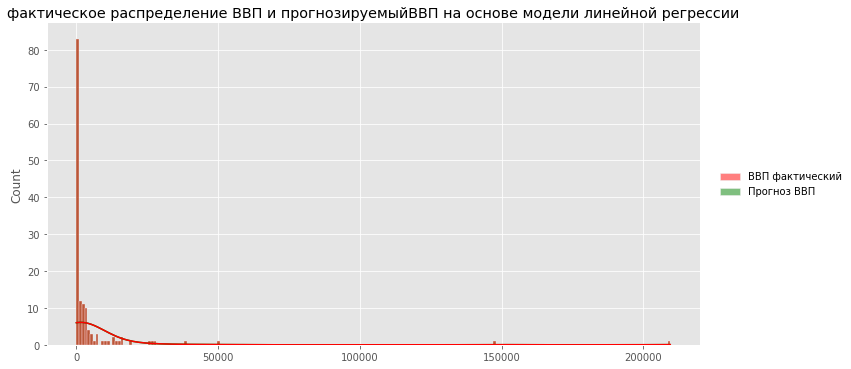

In [28]:
y_pred=modelz.predict(Z)

df[['predict_gdpz']]=y_pred

fig=sns.displot({'ВВП фактический':df['ВВП'],
                 'Прогноз ВВП':df['predict_gdpz']},
                kde=True,palette=['red','green'],
                height=5, aspect=2)

plt.title('фактическое распределение ВВП и прогнозируемый'
          +'ВВП на основе модели линейной регрессии')

plt.show()

### 2.2 Log-linear regression

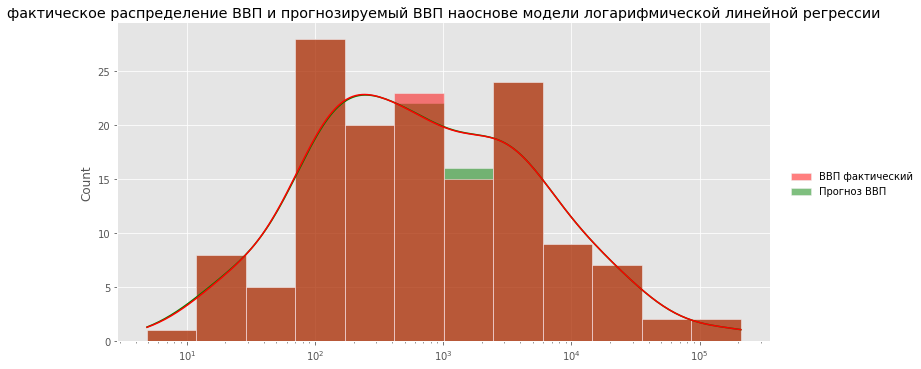

In [29]:
sns.displot({'ВВП фактический':df['ВВП'],
             'Прогноз ВВП':df['predict_gdpz']},
            kde=True,palette=['red','green'],
            height=5, aspect=2,log_scale=True)

plt.title('фактическое распределение ВВП и прогнозируемый ВВП на'+
          'основе модели логарифмической линейной регрессии')

plt.show()

## 3- Model Summary

In [30]:
col_index=['Коэффициент детерминации R^2:',
           'Среднеквадратическая ошибка RMSE:',
           'Формула уравнения:']
df_model=pd.DataFrame(data={'Индикаторы оценки регрессии':col_index,
                            'X1-конечное потребление государства':model1,
                            'X2-конечное потребление':model2,
                            'X3-валовое накопление капитала':model3,
                            'X4-безработица':model4,
                            'X5-чистый экспорт':model5,
                               'Z': col_z})

In [31]:
df_model.head()

,Индикаторы оценки регрессии,X1-конечное потребление государства,X2-конечное потребление,X3-валовое накопление капитала,X4-безработица,X5-чистый экспорт,Z
0,Коэффициент детерминации R^2:,0.979,0.972,0.877,0.004,0.110,1.000
1,Среднеквадратическая ошибка RMSE:,3183.956,3686.841,7710.519,21942.949,20744.744,33.679
2,Формула уравнения:,-534.13 + 6.18*x,162.42 + 1.33*x,997.03 + 3.13*x,7654.90 + -240.37*x,6089.05 + -10.64*x,0.49 + -0.02*x1 +1.02*x2+0.97*x3 +-0.05*x4 + 1...
